# Selection of the relevant sensors

Before entering the process of data preparation for the application of ML methods, it is necesarry to choose the relevant sensors that might have an impact on the label values (in this case, on the external diameter of produced parts  200 mm from the left end).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,sys
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import h5py
from scipy import signal
# before importing, activate your environment and write in Anaconda prompt:
# pip install ipywidgets
# jupyter nbextension enable --py widgetsnbextension
from ipywidgets import interact 
import ipywidgets as widgets

### Files upload, data size and type

Uploading 81 files which correspond to 81 production parts.

In [3]:
scope_traces=[] #this will be the list of dataframes
file_names=os.listdir('Data/AFRC Radial Forge - Zenodoo Upload v3/Data/ScopeTraces')

Upload check

In [4]:
file_names[0]

'Scope0001.csv'

Creating the list of dataframes for the uploaded files:

In [5]:
for file in file_names:
    df=pd.read_csv("Data\\AFRC Radial Forge - Zenodoo Upload v3\\Data\\ScopeTraces\\"+file,encoding = 'unicode_escape') 
    scope_traces.append(df)

In [6]:
type(scope_traces[0]) #checking the type of element in the list (dataframe)

pandas.core.frame.DataFrame

A total number of 81 files (81 sensors' cycles or 81 produced parts per day in the forging process) is analyzed. The first file contains 23328 rows (corresponding to the time samples from 97 sensors). Later, it is going to be discovered that the number of rows differs among all files.

In [7]:
scope_traces[0].head()

,Timer Tick [ms],Block-Nr,Power [kW],Force [kN],A_ges_vibr,Schlagzahl [1/min],EXZ_pos [deg],hydraulic low pressure [bar],hydraulic high pressure [bar],A_ACTpos [mm],...,O_MASTOP,c01w,c02w,$U_GH_NOMVAL_1 (U25W1),$H1P_Y12 (U11S17),$H1P_Y11 (U11S7),$U_GH_NOMEXT_2 (U26S1),$U_GH_HEATON_2 (U26S0),$U_GH_NOMEXT_1 (U25S1),$U_GH_HEATON_1 (U25S0).1
0,2594955190,10,50.453915,0.0,7.880536,1207.22081,31.204766,115.256693,202.028443,1207.685,...,0,1,0,0,0,1,1,0,1,0
1,2594955200,10,50.454423,0.0,6.334391,1209.64038,103.758477,115.233426,201.954750,1207.685,...,0,1,0,0,0,1,1,0,1,0
2,2594955210,10,50.453662,0.0,5.486467,1205.96980,176.092461,115.138935,201.898792,1207.680,...,0,1,0,0,0,1,1,0,1,0
3,2594955220,10,50.450142,0.0,114.403358,1210.00307,248.690117,114.985305,201.841733,1207.550,...,0,1,0,0,0,1,1,0,1,0
4,2594955230,10,50.447115,0.0,381.107631,1209.25234,321.024102,114.858741,201.783774,1207.240,...,0,1,0,0,0,1,1,0,1,0


In [8]:
scope_traces[0].shape #file size

(23328, 99)

For each dataframe, it is possible to check the type of values in all columns. It is expected that all values are integers *int* or real numbers *float64* because they represent measuring data from the sensors. To demonstrate this step, it will be done on one file.

In [9]:
scope_traces[0].dtypes

Timer Tick [ms]                    int64
Block-Nr                           int64
Power [kW]                       float64
Force [kN]                       float64
A_ges_vibr                       float64
Schlagzahl [1/min]               float64
EXZ_pos [deg]                    float64
hydraulic low pressure [bar]     float64
hydraulic high pressure [bar]    float64
A_ACTpos [mm]                    float64
B_ACTpos [mm]                    float64
DB_ACTpos [mm]                   float64
D_ACTpos [mm]                    float64
L_ACTpos [mm]                    float64
R_ACTpos [mm]                    float64
SBA_ActPos [mm]                  float64
INDA_ACTpos [deg]                float64
A_ACT_Force [kN]                 float64
B_ACT_Force [kN]                 float64
DB_ACT_Force [kN]                float64
D_ACT_Force [kN]                 float64
L_ACTspd [mm/min]                float64
R_ACTspd [mm/min]                float64
SBA_NomPos [mm] [mm]             float64
INDA_NOMspd [U/m

So, there are 99 sensors in total. According to the file 'ForgedPartDataStructureSummaryv3' in *Data* folder, sensors that are used for auxiliary process measurement or that are not used at all, are removed from the further analysis. List *sensors_in_use* contains data for all other sensors, which are going to be explored more thoroughly.

In [10]:
sensors_in_use=[None]*len(scope_traces)
sensors_in_use=[scope_traces[i].drop(columns=['A_NOM_Force [kN]','B_ACTpos [mm]','B_ACT_Force [kN]','B_ACTspd [mm/min]','B_NOMpos [mm]','B_OUT [%]','B_NOMspd [mm/min]','B_NOM_Force [kN]','Feedback B [%]','DB_NOM_Force [kN]','D_ACTpos [mm]','D_ACT_Force [kN]','D_ACTspd [mm/min]','D_NOMpos [mm]','D_OUT [%]','D_NOMspd [mm/min]','D_NOM_Force [kN]','Feedback D [%]','$F_F41L (I14S8)',
'hydraulic low pressure [bar]','hydraulic high pressure [bar]','Lub_ActSpd [rpm]','Hyd_ActSpd [rpm]','$U_GH_HEATON_1 (U25S0)','O_EMERG','STP || EM','O_MASTOP','$U_GH_NOMVAL_1 (U25W1)','$H1P_Y12 (U11S17)','$H1P_Y11 (U11S7)','$U_GH_NOMEXT_2 (U26S1)','$U_GH_HEATON_2 (U26S0)','$U_GH_NOMEXT_1 (U25S1)','$E_GH_FAULT_2 (I26S21)','$E_GH_FAULT_1 (I25S21)','$B12R_Y11 (U14S16)','Timer Tick [ms]','Block-Nr']) for i in range(len(scope_traces))]


Plots, descriptive statistics and correlation matrix are used for selection of the relevant sensors. This is an interative process, which means that these steps are repeated many times in order to observe behaviour of the sensors in different phases of forging.

Function `df_summary` calculates descriptive statistics for all of the sensors and each produced part (it can be adjusted by Slider. From the values of the mean and standard deviation, it can be concluded that the following sensors have very low standard deviation in comparison with the mean, which means that their features might not be significant at all for the ML methods:
- Schlagzahl [1/min]
- L1.R_B41 [bar] 
- ForgingBox_Temp
- RamRetract_ActSpd [rpm]

Before excluding them from the further analysis, some additional checks are going to come into place. Some sensors have very high deviations from the mean value, or maximum values much different from the mean and standard deviation. It can implicate that these sensors show almost constant values during some part of the time and than they become "active" in some other part of the time when they show different values. It can be noticed that for some sensors, 50% region and 75% region are much different from the maximum values (for example: DB_ACTpos [mm]). 

In [11]:
pd.options.display.max_columns = 4000

In [12]:
def df_summary(i):
    print("Part",sensors_in_use[i].describe())
interact(df_summary,i=widgets.IntSlider(min=0, max=81, step=1))  


interactive(children=(IntSlider(value=0, description='i', max=81), Output()), _dom_classes=('widget-interact',…

<function __main__.df_summary(i)>

Function `calculate_correlation` calculates the mean values of correlation coefficients between sensors for 81 measurement cycles (production of 81 parts). It can be concluded that some sensors have very high correlation coefficients and that some of them might affect the labels as duplicates of other sensors. For example:

- L_ACTspd [mm/min] vs  R_ACTspd [mm/min] 1
- L_NOMpos [mm] vs  R_NOMpos [mm] 1
- L_OUT [%]  vs  R_OUT [%] 1
- L_NOMspd [mm/min]  vs R_NOMspd [mm/min] 11
- Feedback L [%] vs  Feedback R [%] =1
- Power [kW]	vs Force [kN] 0.96
- INDA_NOMspd [U/min] vs A_ACTpos [mm] -0.99
- R_NOMpos [mm] vs A_ACTpos [mm]  0.93
- INDA_NOMpos [deg] vs A_ACTpos [mm] -0.91
- A_NOMpos [mm] vs A_ACTpos [mm]  0.98
- INDA_OUT [%] vs A_ACTpos [mm] -0.99
- INDA_ACTspd [U/min] vs A_ACTpos [mm] -0.99
- NOMforceSPA [kN] vs A_ACTpos [mm] -0.92
- ACTforceSPA [kN] vs A_ACTpos [mm] -0.92
- W2 Durchfluss [I] vs   A_ACTpos [mm] -0.91

Because of this, Power sensor is going to be excluded, as well as sensors: L_ACTspd [mm/min], L_NOMpos [mm], L_OUT [%], L_NOMspd [mm/min], Feedback L [%] ,  INDA_NOMspd [U/min], R_NOMpos [mm] , INDA_NOMpos [deg], A_NOMpos [mm] , INDA_OUT [%], INDA_ACTspd [U/min], NOMforceSPA [kN], ACTforceSPA [kN], W2 Durchfluss [I] .

In [13]:
def calculate_correlation(sensors):
    correlation_list=[sensors[i].corr().values for i in range(len(sensors))]
    correlation_array=np.array(correlation_list)
    print("Correlation array dimensions:",correlation_array.shape)
    corr_mean=np.mean(correlation_array,axis=0)
    print("Mean value of correlation coefficients for all sensors:")
    corr_mean_df=pd.DataFrame(corr_mean,columns=sensors[0].columns,index=sensors[0].columns)
    return corr_mean_df.style.background_gradient(cmap='coolwarm').set_precision(2)

In [14]:
calculate_correlation(sensors_in_use)

Correlation array dimensions: (81, 61, 61)
Mean value of correlation coefficients for all sensors:


In [15]:
sensors_in_use=[sensors_in_use[i].drop(columns=['Power [kW]','L_ACTspd [mm/min]','L_NOMpos [mm]','L_OUT [%]','L_NOMspd [mm/min]','Feedback L [%]','INDA_NOMspd [U/min]','R_NOMpos [mm]','INDA_NOMpos [deg]','A_NOMpos [mm]','INDA_OUT [%]','INDA_ACTspd [U/min]',
                                       'NOMforceSPA [kN]','ACTforceSPA [kN]','W2 Durchfluss [l]']) for i in range(len(scope_traces))]

Now, the plots for the rest of the sensors are examined.

In [16]:
def plot_sensors(i):
    column_names=sensors_in_use[i].columns
    for column in column_names:
        fig = plt.figure(figsize=(4,4)) # define plot area
        plt.plot(np.arange(0,(sensors_in_use[i].shape[0]/100),0.01),sensors_in_use[i][column].values)
        plt.xlabel("Time, s")
        plt.ylabel(column)
        plt.show()
interact(plot_sensors,i=widgets.IntSlider(min=0, max=80, step=1))  

interactive(children=(IntSlider(value=0, description='i', max=80), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_sensors(i)>

Some of the sensors produce signals which do not look like they affect some particular phase of the forging process. For some of the sensors, it marks their low standard deviation (Schlagzahl [1/min], L1.R_B41 [bar] , ForgingBox_Temp, RamRetract_ActSpd [rpm]. These sensors are excluded from the further observation.

In [17]:
sensors_in_use=[sensors_in_use[i].drop(columns=['EXZ_pos [deg]','L_ACTpos [mm]','IP_ActSpd [mm/min]','IP_NomSpd [mm/min]','RamRetract_ActSpd [rpm]','IP_Out [%]','L1.R_B41 [bar]',
'ForgingBox_Temp','Schlagzahl [1/min]']) for i in range(len(sensors_in_use))]

In [18]:
sensors_in_use[0].shape

(23328, 37)

In [19]:
calculate_correlation(sensors_in_use)

Correlation array dimensions: (81, 37, 37)
Mean value of correlation coefficients for all sensors:


It can be seen that some high correlation coefficients (above 0.9) still exist. 
- SBA_ActPos [mm]vs SBA_NomPos [mm]
- Feedback SBA [%] vs SBA_OUT [%]

- DB_NOMpos [mm] vs DB_ACTpos [mm]
- DB_OUT [%] vs DB_ACTspd [mm/min] 
- Feedback DB [%] vs DB_ACTspd [mm/min] 
- DB_NOMspd [mm/min] DB_ACTspd [mm/min]

- R_NOMspd [mm/min] vs R_ACTspd [mm/min]
- R_OUT [%] R_ACTspd [mm/min]=1
- Feedback R [%]	vs  R_ACTspd [mm/min]

- A_OUT [%] vs A_ACTspd [mm/min] 
- A_NOMspd [mm/min]	vs A_ACTspd [mm/min] 
- Feedback A [%]	vs  A_ACTspd [mm/min]

- Feedback_SPA [%] vs SPA_OUT [%]	
- IP_NomPos vs IP_ActPos [mm]


In [20]:
sensors_in_use=[sensors_in_use[i].drop(columns=['SBA_ActPos [mm]','DB_NOMpos [mm]','R_OUT [%]','R_NOMspd [mm/min]','Feedback R [%]',
                                               'A_OUT [%]','A_NOMspd [mm/min]','Feedback A [%]','DB_OUT [%]','DB_NOMspd [mm/min]','Feedback DB [%]','SBA_OUT [%]','IP_NomPos','Feedback_SPA [%]']) for i in range(len(sensors_in_use))]

In [21]:
sensors_in_use[0].shape

(23328, 23)

Now, plots for the rest of the sensors and their correlation coefficients can be shown. It can be noticed that some sensors still have high correlation coefficients and that some show significant change somwehere near the end of production process (forging phase). Because of this, sensors are divided into two groups, *heating sensors* and *forging sensors* according to the phase in which their behaviour might be significant.

In [22]:
def plot_sensors(i):
    column_names=sensors_in_use[i].columns
    for column in column_names:
        fig = plt.figure(figsize=(4,4)) # define plot area
        plt.plot(np.arange(0,(sensors_in_use[i].shape[0]/100),0.01),sensors_in_use[i][column].values)
        plt.xlabel("Time, s")
        plt.ylabel(column)
        plt.show()
interact(plot_sensors,i=widgets.IntSlider(min=0, max=80, step=1))  

interactive(children=(IntSlider(value=0, description='i', max=80), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_sensors(i)>

In [23]:
calculate_correlation(sensors_in_use)

Correlation array dimensions: (81, 23, 23)
Mean value of correlation coefficients for all sensors:


,Force [kN],A_ges_vibr,A_ACTpos [mm],DB_ACTpos [mm],R_ACTpos [mm],INDA_ACTpos [deg],A_ACT_Force [kN],DB_ACT_Force [kN],R_ACTspd [mm/min],SBA_NomPos [mm] [mm],A_ACTspd [mm/min],DB_ACTspd [mm/min],Feedback SBA [%],Frc_Volt,Speed Vn_1 [rpm],IP_ActPos [mm],SPA_OUT [%],TMP_Ind_U1 [°C],TMP_Ind_F [°C],W1 Durchfluss [l],c01w,c02w,$U_GH_HEATON_1 (U25S0).1
Force [kN],1,0.25,-0.78,-0.28,-0.65,0.53,0.28,0.089,-0.41,-0.00036,0.043,0.0029,0.0012,0.44,0.57,0.54,-0.64,-0.52,-0.062,0.85,-0.63,-0.07,-0.45
A_ges_vibr,0.25,1,-0.31,0.019,-0.25,0.26,0.13,-0.014,-0.032,0.0008,0.0057,0.022,0.00014,0.12,0.26,0.2,-0.33,-0.25,0.2,0.19,-0.34,0.015,-0.17
A_ACTpos [mm],-0.78,-0.31,1,0.042,0.81,-0.72,-0.26,0.072,0.38,5.8e-05,0.0096,-0.11,-0.00098,-0.37,-0.76,-0.51,0.84,0.67,-0.12,-0.59,0.83,0.13,0.44
DB_ACTpos [mm],-0.28,0.019,0.042,1,-0.27,0.029,-0.063,-0.16,0.5,0.00018,0.19,-0.002,-0.00056,-0.043,0.012,-0.31,-0.17,-0.023,0.39,-0.28,-0.25,0.63,0.33
R_ACTpos [mm],-0.65,-0.25,0.81,-0.27,1,-0.62,-0.059,0.13,0.002,8.9e-05,-0.22,-0.17,-0.0016,-0.34,-0.65,-0.29,0.77,0.56,-0.25,-0.52,0.77,0.018,0.25
INDA_ACTpos [deg],0.53,0.26,-0.72,0.029,-0.62,1,0.16,-0.08,-0.2,-5e-05,0.051,0.082,0.00072,0.25,0.56,0.35,-0.62,-0.49,0.16,0.39,-0.62,-0.078,-0.3
A_ACT_Force [kN],0.28,0.13,-0.26,-0.063,-0.059,0.16,1,0.078,-0.29,-0.24,-0.42,-0.02,-0.23,0.091,0.08,0.24,-0.24,-0.23,-0.076,0.28,-0.23,0.07,-0.22
DB_ACT_Force [kN],0.089,-0.014,0.072,-0.16,0.13,-0.08,0.078,1,-0.18,0.075,-0.0015,-0.17,0.17,-0.049,0.0066,0.0069,0.11,0.084,-0.17,0.27,0.13,-0.13,0.00045
R_ACTspd [mm/min],-0.41,-0.032,0.38,0.5,0.002,-0.2,-0.29,-0.18,1,0.001,0.26,0.013,0.007,-0.14,-0.24,-0.28,0.037,0.19,0.37,-0.34,-0.00012,0.4,0.26
SBA_NomPos [mm] [mm],-0.00036,0.0008,5.8e-05,0.00018,8.9e-05,-5e-05,-0.24,0.075,0.001,1,-0.0045,0.018,0.37,0.053,0.088,-8.1e-05,0.0011,6.3e-05,2.4e-05,-0.00016,7.5e-05,3.5e-05,8.4e-05


In [24]:
forging_sensors=[None]*len(sensors_in_use)
forging_sensors=[sensors_in_use[i][['Force [kN]','A_ges_vibr','A_ACTpos [mm]', 'DB_ACTpos [mm]',
       'R_ACTpos [mm]', 'INDA_ACTpos [deg]', 'A_ACT_Force [kN]',
       'DB_ACT_Force [kN]', 'R_ACTspd [mm/min]', 'SBA_NomPos [mm] [mm]',
       'A_ACTspd [mm/min]', 'DB_ACTspd [mm/min]', 'Feedback SBA [%]',
       'Frc_Volt', 'Speed Vn_1 [rpm]', 'IP_ActPos [mm]', 'SPA_OUT [%]','TMP_Ind_F [°C]', 'W1 Durchfluss [l]', 'c01w','c02w']] for i in range(len(sensors_in_use))]

In [25]:
heating_sensor=[None]*len(sensors_in_use)
heating_sensor=[sensors_in_use[i][['TMP_Ind_U1 [°C]']] for i in range(len(sensors_in_use))]

From the previous heatmap, it can be seen that some sensors still have high correlation coefficients. According to the table from literature*, absolute values of correlation coefficients higher than 0.8 are considered as signs of strong correlation. Because of this, the number of sensors for the future analysis is reduced even more.

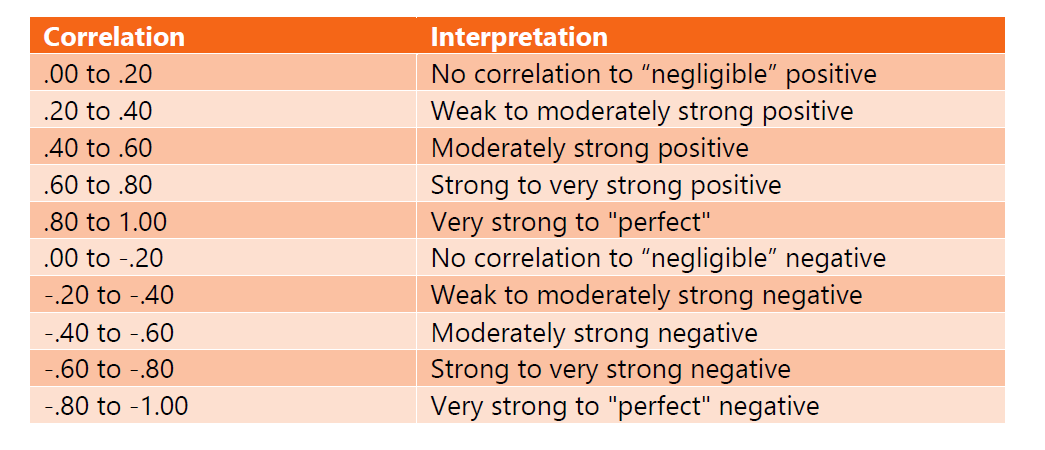

In [34]:
def show_high_corr(sensors):
    correlation_list=[sensors[i].corr().values for i in range(len(sensors))]
    correlation_array=np.array(correlation_list)
    print("Correlation array dimensions:",correlation_array.shape)
    corr_mean=np.mean(correlation_array,axis=0)
    print("Mean value of correlation coefficients for all sensors:")
    corr_mean_df=pd.DataFrame(corr_mean,columns=sensors[0].columns,index=sensors[0].columns)
    # set equality (self correlation) as zero
    corr_mean_df=corr_mean_df.abs()
    corr_mean_df[corr_mean_df == 1] = 0

    # of each feature, find the max correlation
    # and sort the resulting array in ascending order
    corr_mean_cols = corr_mean_df.max().sort_values(ascending=False)

    # display the highly correlated features
    display(corr_mean_cols[corr_mean_cols > 0.8])

In [35]:
show_high_corr(forging_sensors)

Correlation array dimensions: (81, 21, 21)
Mean value of correlation coefficients for all sensors:


Force [kN]           0.850070
W1 Durchfluss [l]    0.850070
A_ACTpos [mm]        0.842529
SPA_OUT [%]          0.842529
c01w                 0.826942
R_ACTpos [mm]        0.809859
dtype: float64

In [36]:
forging_sensors=[forging_sensors[i].drop(columns=['W1 Durchfluss [l]','SPA_OUT [%]','c01w','R_ACTpos [mm]']) for i in range(len(forging_sensors))]

In [38]:
forging_sensors[0].shape

(23328, 17)

In [39]:
forging_sensors[0].columns

Index(['Force [kN]', 'A_ges_vibr', 'A_ACTpos [mm]', 'DB_ACTpos [mm]',
       'INDA_ACTpos [deg]', 'A_ACT_Force [kN]', 'DB_ACT_Force [kN]',
       'R_ACTspd [mm/min]', 'SBA_NomPos [mm] [mm]', 'A_ACTspd [mm/min]',
       'DB_ACTspd [mm/min]', 'Feedback SBA [%]', 'Frc_Volt',
       'Speed Vn_1 [rpm]', 'IP_ActPos [mm]', 'TMP_Ind_F [°C]', 'c02w'],
      dtype='object')

From the next plot, it can be concluded that measurement data from the sensors should be normalized, considering the large differences in values from different sensors.

In [49]:
def show_forging_phase(i):
    forging_sensors[i].plot(figsize=(15,10))
interact( show_forging_phase,i=widgets.IntSlider(min=0, max=80, step=1))  

interactive(children=(IntSlider(value=0, description='i', max=80), Output()), _dom_classes=('widget-interact',…

<function __main__.show_forging_phase(i)>

# END